In [1]:
import pandas as pd
import sqlite3

In [2]:
conn = sqlite3.connect('/Users/orestis/MyProjects/InvestorAPI/app/database/ibd.db')
query = "SELECT * FROM price_prediction_dataset ORDER BY DATE(fiscal_date_ending)"

stocks_df = pd.read_sql(query, conn)

In [ ]:
stocks_df.info()

## Drop rows with null values

In [3]:
columns_with_null = stocks_df.columns[stocks_df.isna().any()].tolist()
stocks_df.dropna(subset=columns_with_null, inplace=True)
stocks_df.reset_index(inplace=True)

## Split the data in training and test set

In [4]:
from typing import Tuple
import datetime as dt

def split_data_to_train_and_test(
    df: pd.DataFrame,
    cutoff_date: dt.datetime,
    cutoff_date_column_name: str = "fiscal_date_ending"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns (train_set_df, test_set_df)
    """
    df['DateColumn'] = pd.to_datetime(df['fiscal_date_ending'])
    # Split the data into train and test based on the cutoff date
    train_set = df[df['DateColumn'] < cutoff_date].copy()
    test_set = df[df['DateColumn'] >= cutoff_date].copy()

    train_set.drop(['DateColumn',], axis=1, inplace=True)
    test_set.drop(['DateColumn',], axis=1, inplace=True)
    
    train_set = train_set.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)

    return train_set, test_set

In [5]:
train_set, test_set = split_data_to_train_and_test(df=stocks_df.copy(), cutoff_date=dt.datetime(2023, 6, 1))

In [6]:
train_set.drop(['index', 'symbol', 'fiscal_date_ending', 'reported_currency' ], axis=1, inplace=True)
test_set.drop(['index', 'symbol', 'fiscal_date_ending', 'reported_currency' ], axis=1, inplace=True)

In [ ]:
train_set.head()

In [ ]:
test_set.head()

In [7]:
from typing import List, Optional

from sklearn.preprocessing import OneHotEncoder

def perform_one_hot_encoding(
    df: pd.DataFrame,
    encoder: OneHotEncoder,
    fit: bool = False,
    categorical_columns: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Given a dataframe with categorical columns this function will return a new dataframe
    that will replace these columns with the one hot encoding ones and will leave the rest
    of the columns unchanged.
    params:
    - fit -> If fit is True then fit_transform is called , otherwise only transform
    - categorical_columns -> A list with the names of the categorical columns we want to
    transform. If not given then columns with type category are used
    """

    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include='category').columns.tolist()

    if fit: 
        encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]).toarray(), columns=encoder.get_feature_names_out())
    else:
        encoded_df = pd.DataFrame(encoder.transform(df[categorical_columns]).toarray(), columns=encoder.get_feature_names_out())

    #merge one-hot encoded columns back with original DataFrame
    final_df = df.join(encoded_df)

    # Drop original categorical columns
    final_df.drop(categorical_columns, axis=1, inplace=True)

    return final_df.reset_index(drop=True)


In [8]:
from typing import List, Optional

from sklearn.preprocessing import MinMaxScaler

def perform_min_max_scaling(
    df: pd.DataFrame,
    min_max_scaler: MinMaxScaler,
    fit: bool = False,
    columns_to_scale: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Given a dataframe with numerical columns this function will return a new dataframe
    that will perform min max scaling on these columns and will leave the rest
    of the columns unchanged.
    params:
    - fit -> If fit is True then fit_transform is called , otherwise only transform
    - columns_to_scale -> A list with the names of the numerical columns we want to
    transform. If not given then columns with type float64 are used
    """

    if columns_to_scale is None:
        columns_to_scale = df.select_dtypes(include='float64').columns.tolist()

    scaled_df = df.copy()
    # Scale the specified columns
    if fit:
        scaled_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    else:
        scaled_df[columns_to_scale] = scaler.transform(df[columns_to_scale])

    return scaled_df

In [9]:
float_columns = stocks_df.select_dtypes(include=['float64'])

# Get the column names of the selected columns
columns_to_scale = list(float_columns.columns)
# Remove target variable from the columns to scale
columns_to_scale.remove('price')

In [10]:
categorical_columns = ['sector']

In [11]:
encoder = OneHotEncoder()
one_hot_encoded_train_set = perform_one_hot_encoding(
    df=train_set,
    categorical_columns=categorical_columns,
    encoder=encoder,
    fit=True
)

one_hot_encoded_test_set = perform_one_hot_encoding(
    df=test_set,
    categorical_columns=categorical_columns,
    encoder=encoder,
    fit=False
)

In [ ]:
one_hot_encoded_train_set.head()

In [12]:
scaler = MinMaxScaler()
scaled_train_set = perform_min_max_scaling(
    df=one_hot_encoded_train_set,
    min_max_scaler=scaler,
    fit=True,
    columns_to_scale=columns_to_scale
)

scaled_test_set = perform_min_max_scaling(
    df=one_hot_encoded_test_set,
    min_max_scaler=scaler,
    fit=False,
    columns_to_scale=columns_to_scale
)

In [ ]:
scaled_train_set

In [13]:
y_train = scaled_train_set['price']
y_train

0          1.750000
1          2.196667
2          2.100000
3          1.776667
4          1.760000
            ...    
53942     26.935000
53943    125.935000
53944     14.245000
53945     22.470000
53946    259.465000
Name: price, Length: 53947, dtype: float64

In [14]:
X_train = scaled_train_set.drop(['price'], axis=1)
X_train

,gross_profit,total_revenue,cost_of_revenue,cost_of_goods_and_services_sold,operating_income,selling_general_and_administrative,research_and_development,operating_expenses,investment_income_net,net_interest_income,...,avg_unemployment_rate,avg_global_commodities_index_value,inflation,sector_ENERGY & TRANSPORTATION,sector_FINANCE,sector_LIFE SCIENCES,sector_MANUFACTURING,sector_REAL ESTATE & CONSTRUCTION,sector_TECHNOLOGY,sector_TRADE & SERVICES
0,0.271768,0.001661,5.811489e-07,5.811489e-07,0.391889,0.000286,0.000242,0.305207,0.593343,0.326890,...,0.491228,0.588252,0.385356,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.271768,0.001661,5.811493e-07,5.811493e-07,0.391889,0.000286,0.000242,0.305207,0.593343,0.326890,...,0.456140,0.631043,0.385356,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.271768,0.001661,5.811477e-07,5.811477e-07,0.391889,0.000286,0.000242,0.305207,0.593343,0.326890,...,0.449761,0.566434,0.247421,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.271768,0.001661,5.811499e-07,5.811499e-07,0.391889,0.000286,0.000242,0.305207,0.593343,0.326890,...,0.433812,0.556092,0.247421,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.271768,0.001661,5.811491e-07,5.811491e-07,0.391889,0.000286,0.000242,0.305207,0.593343,0.326890,...,0.411483,0.554720,0.247421,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53942,0.271768,0.001661,5.811466e-07,5.465157e-07,0.391889,0.000286,0.000242,0.305208,0.596195,0.326890,...,0.012759,0.471141,0.573836,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53943,0.271769,0.001665,5.812570e-07,5.812570e-07,0.391890,0.000286,0.000243,0.305208,0.593409,0.326890,...,0.012759,0.471141,0.573836,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53944,0.271770,0.001665,5.812537e-07,5.811999e-07,0.391888,0.000286,0.000247,0.305210,0.593343,0.326890,...,0.012759,0.471141,0.573836,0.0,0.0,0.0,0.0,0.0,0.0,1.0
53945,0.271771,0.001672,5.813830e-07,5.812643e-07,0.391890,0.000286,0.000243,0.305211,0.593343,0.326889,...,0.012759,0.471141,0.573836,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
y_test = scaled_test_set['price']
y_test

0       531.500000
1        17.816667
2        72.690000
3         1.300000
4        46.326667
           ...    
3153     69.460000
3154     98.775000
3155     61.515000
3156     72.025000
3157     10.165000
Name: price, Length: 3158, dtype: float64

In [18]:
X_test = scaled_test_set.drop(['price'], axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 100 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   gross_profit                                                         3158 non-null   float64
 1   total_revenue                                                        3158 non-null   float64
 2   cost_of_revenue                                                      3158 non-null   float64
 3   cost_of_goods_and_services_sold                                      3158 non-null   float64
 4   operating_income                                                     3158 non-null   float64
 5   selling_general_and_administrative                                   3158 non-null   float64
 6   research_and_development                                             3158 non-null   float64
 7   opera

## Correlation feature selection for numerical data

Feature 0: 6.980390
Feature 1: 7.986670
Feature 2: 0.436592
Feature 3: 0.436597
Feature 4: 4.679691
Feature 5: 0.848845
Feature 6: 0.338313
Feature 7: 3.813745
Feature 8: 74.997680
Feature 9: 4.316830
Feature 10: 10.106138
Feature 11: 10.409253
Feature 12: 1396.916928
Feature 13: 65.741651
Feature 14: 20.949044
Feature 15: 6.071738
Feature 16: 1.755028
Feature 17: 1.394956
Feature 18: 54.601390
Feature 19: 1.082376
Feature 20: 2892.984801
Feature 21: 4.210557
Feature 22: 5.722525
Feature 23: 0.747322
Feature 24: 18.060600
Feature 25: 17.669441
Feature 26: 0.041562
Feature 27: 0.041515
Feature 28: 0.149622
Feature 29: 1740.894926
Feature 30: 16.942879
Feature 31: 7.713063
Feature 32: 115.131586
Feature 33: 0.078024
Feature 34: 0.101687
Feature 35: 0.182516
Feature 36: 30.952608
Feature 37: 9.974220
Feature 38: 6.703733
Feature 39: 6.928102
Feature 40: 1012.902197
Feature 41: 17.023527
Feature 42: 4.583218
Feature 43: 1924.861277
Feature 44: 379.979700
Feature 45: 89.126079
Feature 46: 0

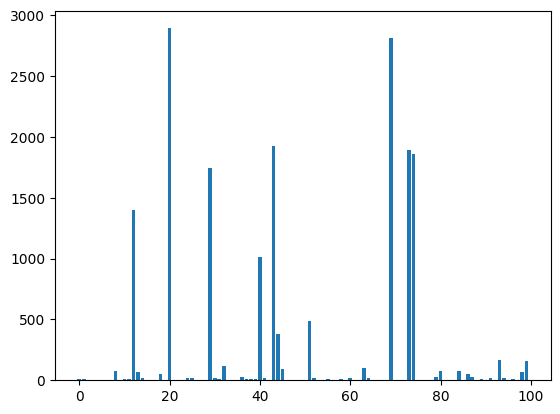

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
correlation_scores = list()
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    correlation_scores.append((i, fs.scores_[i]))

# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

## Mutual information feature selection for numerical input data

Feature 0: 0.124069
Feature 1: 0.118316
Feature 2: 0.042785
Feature 3: 0.033663
Feature 4: 0.116600
Feature 5: 0.080870
Feature 6: 0.028051
Feature 7: 0.099285
Feature 8: 0.030775
Feature 9: 0.060342
Feature 10: 0.023180
Feature 11: 0.038259
Feature 12: 0.105496
Feature 13: 0.037706
Feature 14: 0.052463
Feature 15: 0.054909
Feature 16: 0.133919
Feature 17: 0.092311
Feature 18: 0.054835
Feature 19: 0.125442
Feature 20: 0.169977
Feature 21: 0.125743
Feature 22: 0.109802
Feature 23: 0.134296
Feature 24: 0.082240
Feature 25: 0.107120
Feature 26: 0.042445
Feature 27: 0.044621
Feature 28: 0.032929
Feature 29: 0.096747
Feature 30: 0.069344
Feature 31: 0.067316
Feature 32: 0.067516
Feature 33: 0.074810
Feature 34: 0.052614
Feature 35: 0.059331
Feature 36: 0.048572
Feature 37: 0.032051
Feature 38: 0.017872
Feature 39: 0.055499
Feature 40: 0.095673
Feature 41: 0.075551
Feature 42: 0.081421
Feature 43: 0.071518
Feature 44: 0.048165
Feature 45: 0.051022
Feature 46: 0.033123
Feature 47: 0.058594
Fe

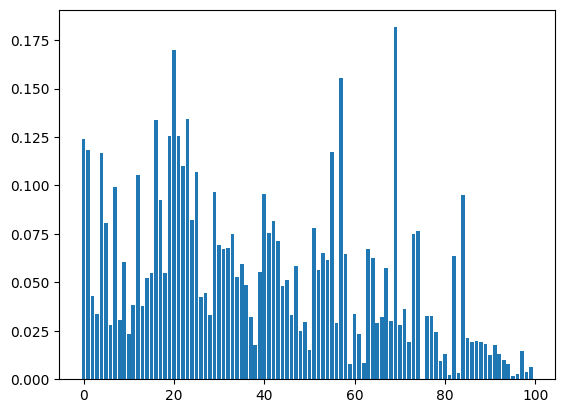

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
mutual_info_scores = list()
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    mutual_info_scores.append((i, fs.scores_[i]))

# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [41]:
mutual_info_scores_sorted = sorted(mutual_info_scores, key=lambda x: x[1], reverse=True)

for mutual_info_score in mutual_info_scores_sorted:
    index = mutual_info_score[0]
    score = mutual_info_score[1]
    print(f"{X_train.columns[index]} -> {score}")

profit_loss -> 0.18162321288653072
comprehensive_income_net_of_tax -> 0.16997744347437038
retained_earnings -> 0.155314504933747
net_income -> 0.13429637091620084
income_before_tax -> 0.1339187241092299
ebit -> 0.12574266365872777
net_income_from_continuing_operations -> 0.1254422919773326
gross_profit -> 0.12406932901087764
total_revenue -> 0.11831557171281348
total_shareholder_equity -> 0.11720092807794735
operating_income -> 0.11660007143926787
ebitda -> 0.1098016055693356
total_current_assets -> 0.10712028587830069
non_interest_income -> 0.10549616306183562
operating_expenses -> 0.09928547111703301
current_net_receivables -> 0.09674696077286171
other_non_current_assets -> 0.0956729026379941
change_in_cash_and_cash_equivalents -> 0.09491258706925976
income_tax_expense -> 0.09231092908816896
total_assets -> 0.08224030777164693
total_current_liabilities -> 0.08142068028114036
selling_general_and_administrative -> 0.0808702689321894
long_term_debt_noncurrent -> 0.0779278786698181
payme

In [42]:
correlation_scores_sorted = sorted(correlation_scores, key=lambda x: x[1], reverse=True)

for correlation_score in correlation_scores_sorted:
    index = correlation_score[0]
    score = correlation_score[1]
    print(f"{X_train.columns[index]} -> {score}")

comprehensive_income_net_of_tax -> 2892.9848009218813
profit_loss -> 2814.006533993898
current_accounts_payable -> 1924.8612765259609
payments_for_repurchase_of_common_stock -> 1893.0308888041313
payments_for_repurchase_of_equity -> 1857.7390916136535
current_net_receivables -> 1740.8949257413494
non_interest_income -> 1396.9169279536745
other_non_current_assets -> 1012.902196753046
long_term_debt_noncurrent -> 489.4295219115554
deferred_revenue -> 379.97969959247905
sector_ENERGY & TRANSPORTATION -> 167.70354678259991
sector_TRADE & SERVICES -> 158.80338855644604
accumulated_depreciation_amortization_ppe -> 115.13158609986068
change_in_operating_liabilities -> 100.14868441281486
current_debt -> 89.12607937477385
change_in_cash_and_cash_equivalents -> 79.66555147165923
proceeds_from_issuance_of_long_term_debt_and_capital_securities_net -> 77.880560345439
investment_income_net -> 74.99767958870606
sector_TECHNOLOGY -> 66.60729887001652
other_non_operating_income -> 65.74165097426808
int